In [1]:

import pandas as pd
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [2]:
#load all dfs form a folder and merge them on ID
""" path = "/zi/home/esra.lenz/Documents/00_HITKIP/09_TABPFN/00_NAKO/00_data/deconfounded_but_age/"
for i, file in enumerate(os.listdir(path)):
    if i == 0:
        df = pd.read_csv(path + file)
    else:
        df = pd.merge(df, pd.read_csv(path + file), on='ID') """
df = pd.read_csv("/zi/home/esra.lenz/Documents/00_HITKIP/09_TABPFN/00_NAKO/00_data/deconfounded_but_age/aseg.volume_aparc.volume_aparc.thickness.csv")
label_df = pd.read_csv("/zi/home/esra.lenz/Documents/00_HITKIP/09_TABPFN/00_NAKO/00_data/age_label/all_ages.csv")

label_df = label_df[['ID', 'label_Age']]

In [3]:
for col in df.columns:
    print(col)

ID
Left-Lateral-Ventricle
Left-Inf-Lat-Vent
Left-Cerebellum-White-Matter
Left-Cerebellum-Cortex
Left-Thalamus
Left-Caudate
Left-Putamen
Left-Pallidum
3rd-Ventricle
4th-Ventricle
Brain-Stem
Left-Hippocampus
Left-Amygdala
CSF
Left-Accumbens-area
Left-VentralDC
Left-vessel
Left-choroid-plexus
Right-Lateral-Ventricle
Right-Inf-Lat-Vent
Right-Cerebellum-White-Matter
Right-Cerebellum-Cortex
Right-Thalamus
Right-Caudate
Right-Putamen
Right-Pallidum
Right-Hippocampus
Right-Amygdala
Right-Accumbens-area
Right-VentralDC
Right-vessel
Right-choroid-plexus
5th-Ventricle
WM-hypointensities
Left-WM-hypointensities
Right-WM-hypointensities
non-WM-hypointensities
Left-non-WM-hypointensities
Right-non-WM-hypointensities
Optic-Chiasm
CC_Posterior
CC_Mid_Posterior
CC_Central
CC_Mid_Anterior
CC_Anterior
BrainSegVol
lhCortexVol
rhCortexVol
CortexVol
lhCerebralWhiteMatterVol
rhCerebralWhiteMatterVol
CerebralWhiteMatterVol
SubCortGrayVol
TotalGrayVol
SupraTentorialVol
SupraTentorialVolNotVent
lh_bankssts_volu

In [4]:
for col in label_df.columns:
    print(col)

ID
label_Age


In [5]:
#merge the dataframes on ID
merged_df = pd.merge(df, label_df, on='ID', how='inner')

In [6]:
print(merged_df["label_Age"].value_counts())
merged_df.dropna(inplace=True)
merged_df = merged_df[:5000]


label_Age
47    531
49    529
50    519
48    506
46    464
51    453
52    421
53    420
44    419
45    400
54    382
43    372
55    363
56    349
63    344
65    340
58    337
64    330
42    322
61    318
62    318
57    314
66    303
60    283
41    271
67    268
59    268
40    255
68    238
29    218
28    201
30    183
27    180
31    172
69    170
32    160
37    159
25    159
26    158
39    152
35    146
36    137
24    135
38    135
23    133
34    129
33    127
70    119
22     94
71     69
21     62
20     24
72     22
19      4
74      1
Name: count, dtype: int64


In [7]:
y = merged_df["label_Age"]
X = merged_df.drop(["ID", "label_Age"], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
def analyze_age_predictions(y_true, y_pred):
    # Calculate basic error metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Calculate absolute differences for each prediction
    differences = np.abs(y_true - y_pred)
    
    # Calculate median absolute error
    median_ae = np.median(differences)
    
    # Calculate percentage of predictions within different year ranges
    within_1_year = np.mean(differences <= 1) * 100
    within_3_years = np.mean(differences <= 3) * 100
    within_5_years = np.mean(differences <= 5) * 100
    
    # Calculate age-specific errors
    age_errors = pd.DataFrame({
        'true_age': y_true,
        'predicted_age': y_pred,
        'absolute_error': differences
    })
    
    age_group_errors = age_errors.groupby(pd.cut(age_errors['true_age'], 
                                                bins=range(0, 101, 10)))['absolute_error'].mean()
    
    # Print results
    print(f"Average Absolute Error: {mae:.2f} years")
    print(f"Root Mean Square Error: {rmse:.2f} years")
    print(f"Median Absolute Error: {median_ae:.2f} years")
    print(f"\nPredictions within:")
    print(f"1 year: {within_1_year:.1f}%")
    print(f"3 years: {within_3_years:.1f}%")
    print(f"5 years: {within_5_years:.1f}%")
    
    # Create error distribution plot
    plt.figure(figsize=(12, 6))
    plt.hist(differences, bins=50, edgecolor='black')
    plt.title('Distribution of Age Prediction Errors')
    plt.xlabel('Absolute Error (Years)')
    plt.ylabel('Frequency')
    plt.axvline(mae, color='red', linestyle='dashed', label=f'Mean Error: {mae:.2f}')
    plt.axvline(median_ae, color='green', linestyle='dashed', label=f'Median Error: {median_ae:.2f}')
    plt.legend()
    plt.show()
    
    # Create scatter plot of true vs predicted ages
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('True vs Predicted Age')
    plt.axis('equal')
    plt.grid(True)
    plt.show()
    
    # Print age group errors
    print("\nAverage Error by Age Group:")
    print(age_group_errors)
    
    return {
        'mae': mae,
        'rmse': rmse,
        'median_ae': median_ae,
        'within_1_year': within_1_year,
        'within_3_years': within_3_years,
        'within_5_years': within_5_years,
        'age_group_errors': age_group_errors
    }

In [10]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score, classification_report
import tabpfn as tp
# Split the dataset


# Initialize the classifier
clf = tp.TabPFNRegressor()
# Fit the model
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)

/zi/home/esra.lenz/.conda/envs/NAKO_CLIP/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/zi/home/esra.lenz/.conda/envs/NAKO_CLIP/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/zi/home/esra.lenz/.conda/envs/NAKO_CLIP/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/zi/home/esra.lenz/.conda/envs/NAKO_CLIP/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.v

In [11]:
# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print comprehensive regression metrics
print("\nRegression Metrics:")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")


Regression Metrics:
Root Mean Squared Error: 5.8876
Mean Absolute Error: 4.6749
R² Score: 0.7799
Explained Variance Score: 0.7820
Mean Absolute Percentage Error: 0.1097


/tmp/ipykernel_1679532/2738891337.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_errors = age_errors.groupby(pd.cut(age_errors['true_age'],


Average Absolute Error: 4.67 years
Root Mean Square Error: 5.89 years
Median Absolute Error: 3.91 years

Predictions within:
1 year: 14.2%
3 years: 39.0%
5 years: 61.5%


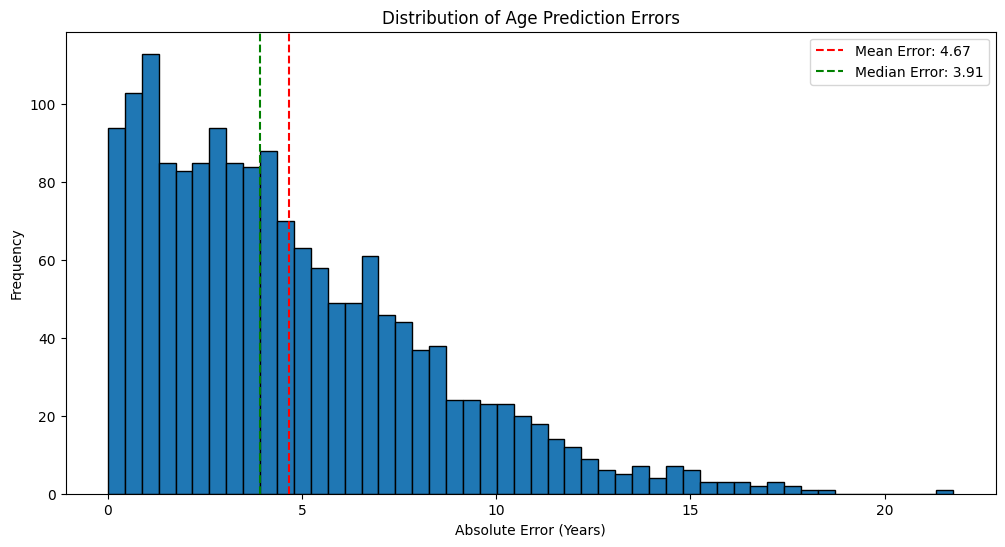

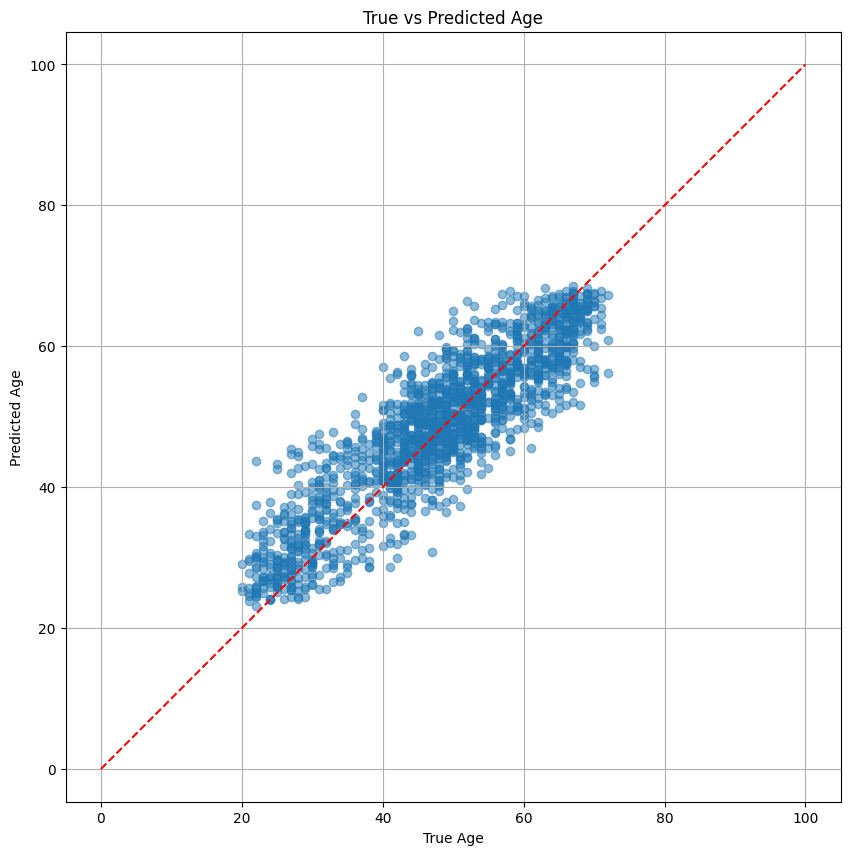


Average Error by Age Group:
true_age
(0, 10]           NaN
(10, 20]     6.733068
(20, 30]     5.546333
(30, 40]     5.715875
(40, 50]     4.286636
(50, 60]     4.178594
(60, 70]     4.591605
(70, 80]     7.494611
(80, 90]          NaN
(90, 100]         NaN
Name: absolute_error, dtype: float64


{'mae': 4.674946308135986,
 'rmse': 5.887647285967872,
 'median_ae': 3.9076080322265625,
 'within_1_year': 14.181818181818182,
 'within_3_years': 38.96969696969697,
 'within_5_years': 61.45454545454545,
 'age_group_errors': true_age
 (0, 10]           NaN
 (10, 20]     6.733068
 (20, 30]     5.546333
 (30, 40]     5.715875
 (40, 50]     4.286636
 (50, 60]     4.178594
 (60, 70]     4.591605
 (70, 80]     7.494611
 (80, 90]          NaN
 (90, 100]         NaN
 Name: absolute_error, dtype: float64}

In [12]:
analyze_age_predictions(y_test, y_pred)

In [13]:
xg_reg = XGBRegressor(random_state=42
)

# Fit the model
xg_reg.fit(
    X_train, 
    y_train,
)



AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [14]:

# Make predictions
y_pred = xg_reg.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print comprehensive regression metrics
print("\nRegression Metrics:")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")


Regression Metrics:
Root Mean Squared Error: 7.4017
Mean Absolute Error: 5.9857
R² Score: 0.6521
Explained Variance Score: 0.6530
Mean Absolute Percentage Error: 0.1424


/tmp/ipykernel_1679532/2738891337.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_errors = age_errors.groupby(pd.cut(age_errors['true_age'],


Average Absolute Error: 5.99 years
Root Mean Square Error: 7.40 years
Median Absolute Error: 5.21 years

Predictions within:
1 year: 10.0%
3 years: 29.3%
5 years: 48.1%


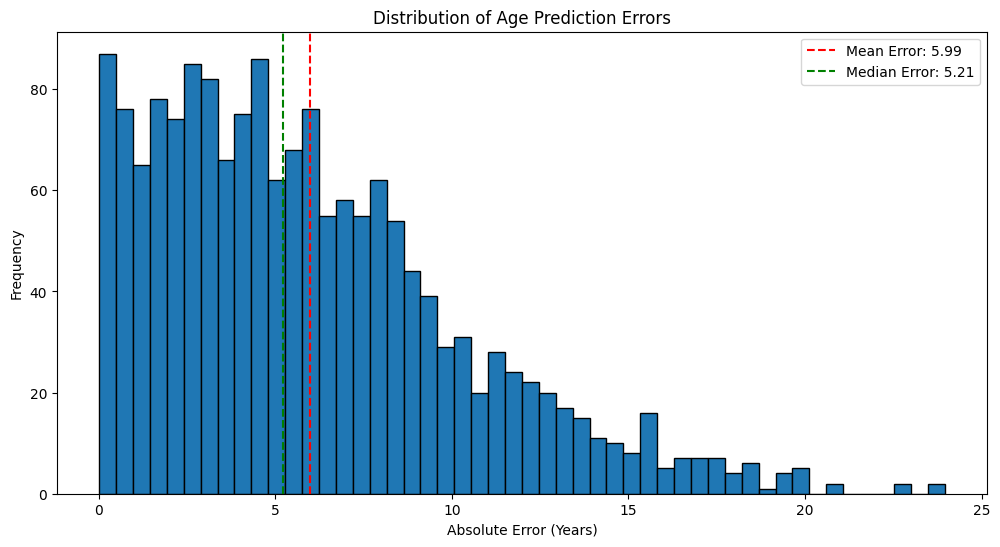

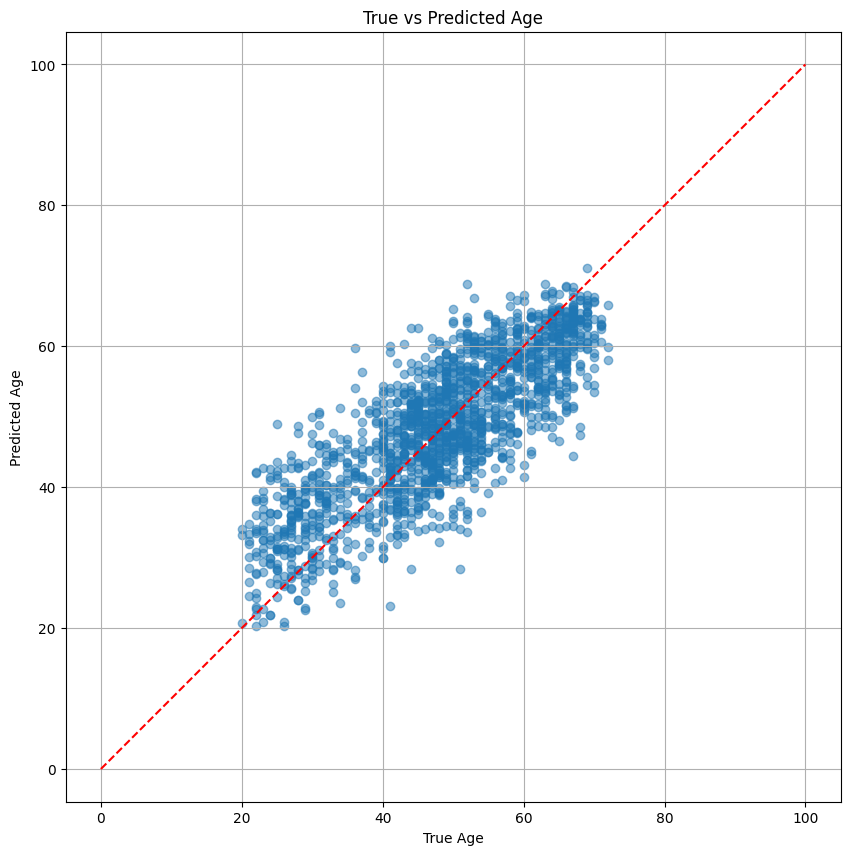


Average Error by Age Group:
true_age
(0, 10]           NaN
(10, 20]     9.294057
(20, 30]     8.194643
(30, 40]     6.732403
(40, 50]     5.198219
(50, 60]     5.486958
(60, 70]     5.852679
(70, 80]     9.124620
(80, 90]          NaN
(90, 100]         NaN
Name: absolute_error, dtype: float64


{'mae': 5.985674858093262,
 'rmse': 7.401671205430621,
 'median_ae': 5.206918716430664,
 'within_1_year': 10.0,
 'within_3_years': 29.333333333333332,
 'within_5_years': 48.06060606060606,
 'age_group_errors': true_age
 (0, 10]           NaN
 (10, 20]     9.294057
 (20, 30]     8.194643
 (30, 40]     6.732403
 (40, 50]     5.198219
 (50, 60]     5.486958
 (60, 70]     5.852679
 (70, 80]     9.124620
 (80, 90]          NaN
 (90, 100]         NaN
 Name: absolute_error, dtype: float64}

In [15]:
analyze_age_predictions(y_test, y_pred)